# Metabolic Syndrome - Analysis of Causes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
 
# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# Load Data
df = pd.read_csv('Data/Metabolic _Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


## Exploration

In [4]:
# Exploring Metabolic Syndrome to determine target
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [5]:
# Checking Marital status
df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [6]:
# Pulling info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [7]:
# Checking duplicates
df.duplicated().sum()

0

In [8]:
# Null check
df.isna().sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [9]:
# Checking stats for any outliers or points of interest
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [10]:
# UrAlbCr and Triglycerides have huge max values.
# Checking if other Triglyceride values are similarly high
test = df.sort_values(['Triglycerides'], ascending=[False])
test['Triglycerides'].head(10)

2092    1562
1016    1311
829      979
2196     814
2076     700
1740     688
681      681
148      668
1979     666
650      626
Name: Triglycerides, dtype: int64

In [11]:
# Running test for UrAlbCr as well
test = df.sort_values(['UrAlbCr'], ascending=[False])
test['UrAlbCr'].head(10)

1557    5928.00
2070    4462.81
910     3666.67
2196    3500.00
140     3284.62
50      3267.57
246     2750.00
324     2403.85
2027    2403.85
1438    2360.66
Name: UrAlbCr, dtype: float64

### These appear to be typical values. We can safely move on.

## Exploratory Visuals

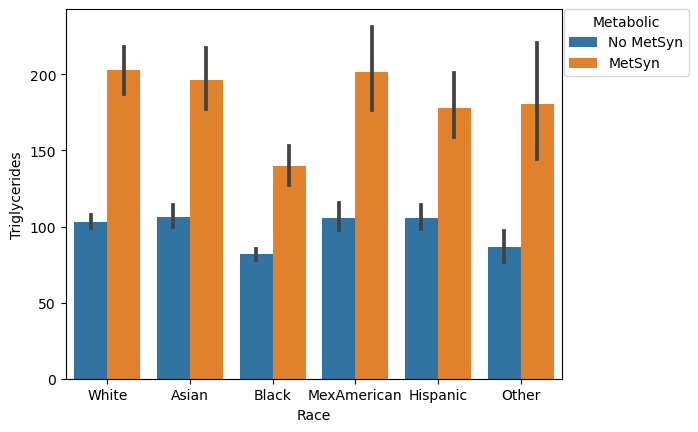

In [12]:
# Exploring data with visuals. Checking if triglycerides has correlation to target
ax = sns.barplot(data=df, x='Race', y='Triglycerides',hue='MetabolicSyndrome')
sns.move_legend(ax, "lower right", bbox_to_anchor=(1.27, .8), title='Metabolic');

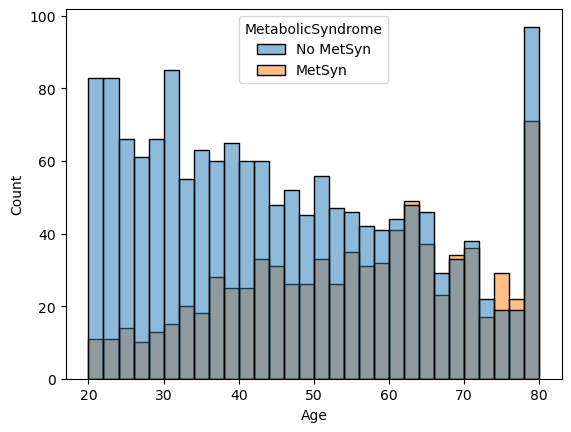

In [13]:
# Let's make a histogram of age, hueing our target
sns.histplot(data=df, x='Age', hue='MetabolicSyndrome', bins=30);

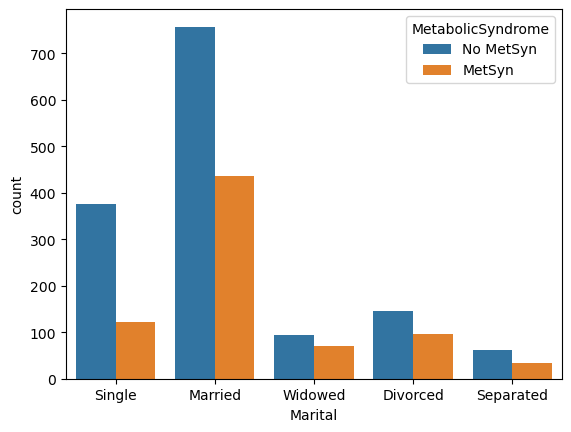

In [14]:
# Let's see if marital status plays any factor. If not we could drop it.
sns.countplot(data=df, x='Marital',hue='MetabolicSyndrome');

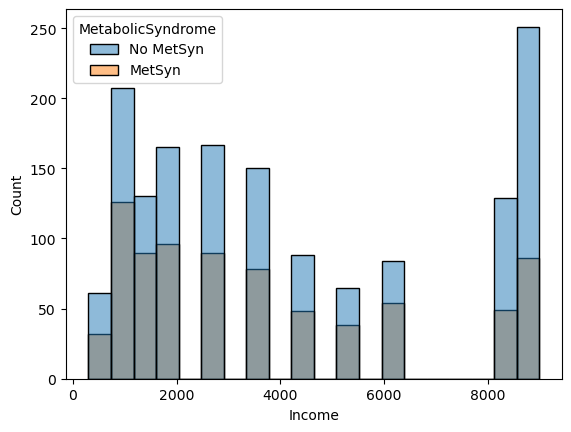

In [15]:
# Checking Income
sns.histplot(data=df,x='Income',hue='MetabolicSyndrome', bins=20);

In [16]:
# Time to define our target and choose which features to remove.
y = df['MetabolicSyndrome'].copy()
# WaistCirc and BMI seem too similar, dropping BMI since waist circumference can be a better indicator of a factor being obesity related.
# Also dropping Income and seqn
X = df.drop(columns = ['MetabolicSyndrome','BMI','Income','seqn']).copy()

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [19]:
# Check the balance of the target. If too imbalanced, we can include SMOTE in our pipeline to even out
y.value_counts(1)

No MetSyn    0.657643
MetSyn       0.342357
Name: MetabolicSyndrome, dtype: float64

In [20]:
# Save lists of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
impute_mode = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
ohe_pipe = make_pipeline(impute_mode, ohe_encoder)
# Making a numeric tuple for ColumnTransformer
#           (choose_a_name, pipeline_or_transformer, list_of_columns)
num_tuple = ('numeric', num_pipe, num_cols)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

Numeric Columns: Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')
OneHotEncoder Columns: Index(['Sex', 'Marital', 'Race'], dtype='object')


In [23]:
# Create the Column Transformer
col_transformer = ColumnTransformer([num_tuple, ohe_tuple], 
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                  verbose_feature_names_out=False)

In [24]:
# Fitting to training and transforming
X_train_tf = col_transformer.fit_transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

,Age,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
1350,1.800453,0.157196,-0.369369,-0.176464,0.999415,0.087320,-0.345774,-0.434660,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,-0.133921,0.567777,-0.369369,-0.089092,0.091315,-0.294390,0.371569,0.180626,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,-1.271788,0.605677,-0.369369,-0.175467,0.161168,-0.411840,-1.063116,0.703620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1709,1.174626,0.359328,-0.369369,-0.141733,0.091315,0.527756,2.914874,-0.762813,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017,1.800453,1.654237,1.988308,-0.038673,1.767808,2.553758,-1.454394,1.195849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Target imbalanced, we can use SMOTE to address
smote = SMOTE(random_state=28)
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

No MetSyn    1196
MetSyn       1196
Name: MetabolicSyndrome, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       1.00      1.00      1.00      1196
   No MetSyn       1.00      1.00      1.00      1196

    accuracy                           1.00      2392
   macro avg       1.00      1.00      1.00      2392
weighted avg       1.00      1.00      1.00      2392



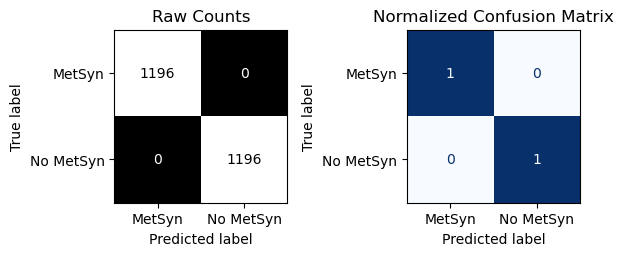


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.86      0.84      0.85       218
   No MetSyn       0.91      0.92      0.92       383

    accuracy                           0.89       601
   macro avg       0.88      0.88      0.88       601
weighted avg       0.89      0.89      0.89       601



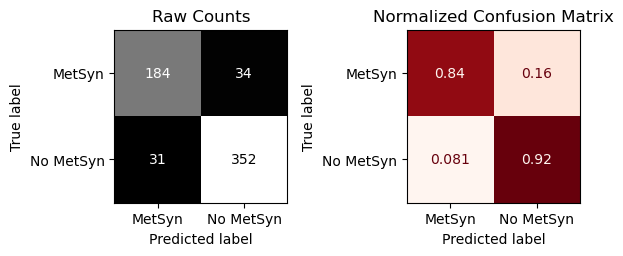

In [26]:
# Instantiate a default random forest with a random state for reproductibility
rf_clf = RandomForestClassifier(random_state=28)

# Fit on the training data
rf_clf.fit(X_train_sm, y_train_sm)

# Evaluate with the custom function
evaluate_classification(rf_clf, X_train_sm, y_train_sm, X_test_tf, y_test)

In [27]:
# From here we'll visualize our top 10 features with permutation importance
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_clf, X_test_tf, y_test, n_repeats =5, random_state = 28)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [28]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

BloodGlucose         0.107155
WaistCirc            0.069551
Triglycerides        0.057238
HDL                  0.030283
UricAcid             0.004659
Sex_Male             0.004659
Race_Black           0.002662
Sex_Female           0.001997
Race_MexAmerican     0.001997
Albuminuria          0.000998
Marital_Separated    0.000666
Race_Other          -0.000333
Age                 -0.000666
Race_Hispanic       -0.001331
Marital_Widowed     -0.001331
Marital_Divorced    -0.001664
Marital_Married     -0.001997
Race_Asian          -0.002329
Race_White          -0.002995
Marital_Single      -0.003661
UrAlbCr             -0.008319
Name: permutation importance, dtype: float64

In [29]:
# We can use a custom function to plot our permutation importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

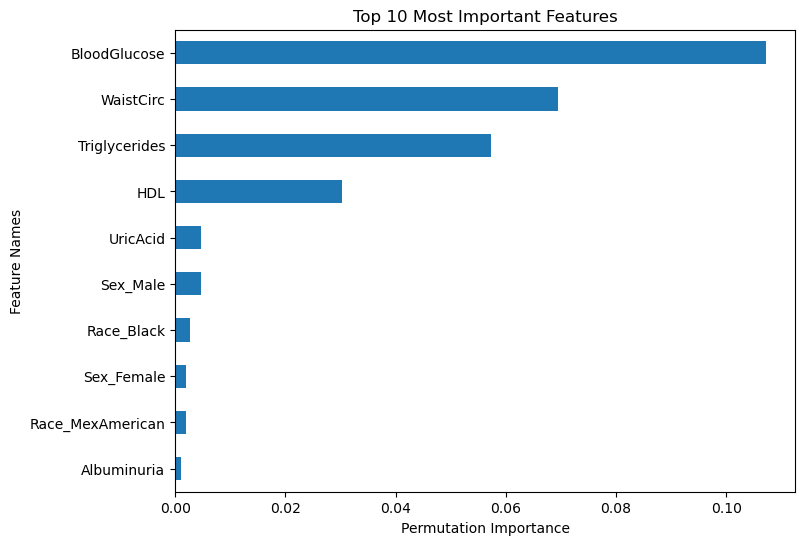

In [30]:
ax = plot_importance(permutation_importances, top_n=10)
ax.set(xlabel='Permutation Importance');

### Given the nature of the dataset (diagnosing Metabolic Syndrome) the emphasized features here make sense. An exploratory visual revealed triglycerides having a strong impact in predicting Metabolic Syndrome. Waist circumference also makes sense. Blood glucose fits too.

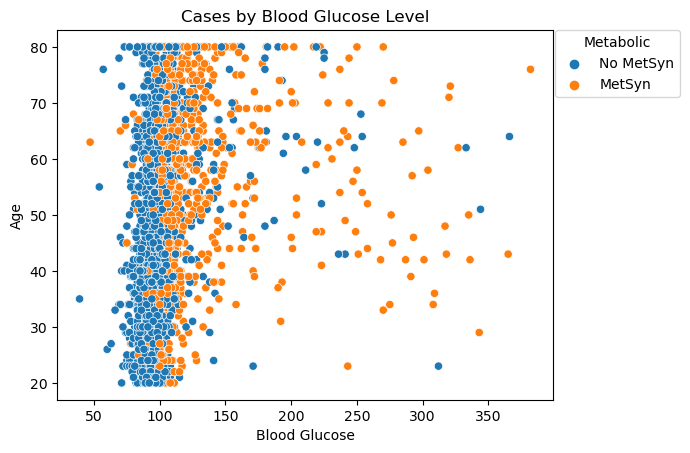

In [31]:
# Let's take a countplot of Blood Glucose
ax = sns.scatterplot(data=df, x='BloodGlucose',y='Age',hue='MetabolicSyndrome')
ax.set(title="Cases by Blood Glucose Level", xlabel="Blood Glucose", ylabel="Age")
sns.move_legend(ax, "lower right", bbox_to_anchor=(1.27, .8), title='Metabolic');

### Here we see, even though Metabolic cases make up a third of all data points, they are strongly represented in higher blood glucose. There appears to be a dense column from 80-110 that's a safe zone for non metabolic syndrome.

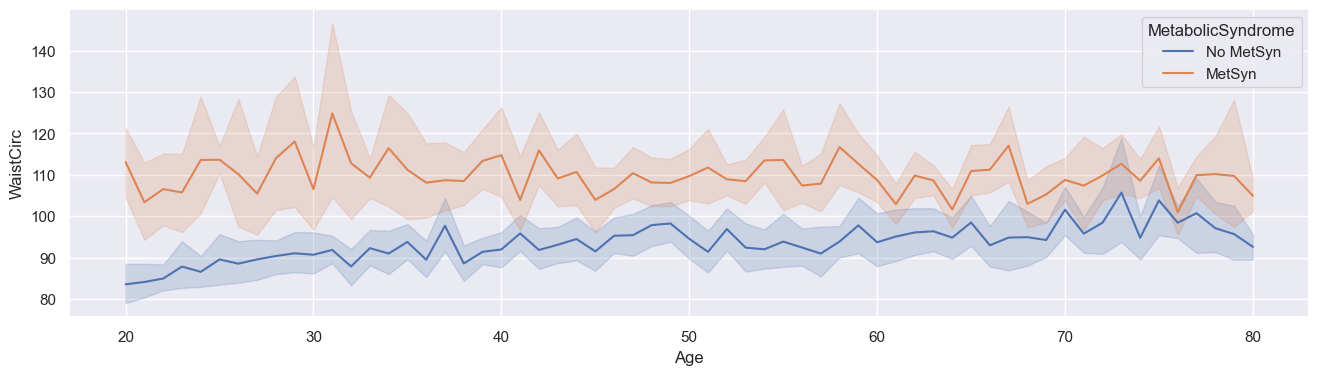

In [37]:
# Let's get a sense of waist circumference in relation to metabolic cases
g = sns.lineplot(data=df, x="Age", y="WaistCirc", hue="MetabolicSyndrome")
sns.set(rc={"figure.figsize": (20, 6)});

### We have a consistently higher waist circumference with all positive metabolic cases regardless of age group. There is a peak in cases around age 32 and pretty steady rate after. At the older ages the lines begin to blur. All told, we wouldn't call age a good predictor of Met Syndrome.